# Right but Why
## Are Tree Ensambles a Black-Box?
Written by Dr. Hanan Shteingart

All Rights Reserved

![](https://image.ibb.co/jOSnJ8/closed_blackbox.png)

# Why?
* Learn how to interpretate predictions of decision tree, random forests and gradient-boosted trees models.

# Use Case
* Imagine a situation where a credit card company has built a fraud detection model using a random forest. 
* The model can classify every transaction as either valid or fraudulent, based on a large number of features. 
* What if, after a transaction is classified as fraudulent, the analyst would like to know why the model made this decision, i.e. how much each feature contributed to the final outcome?

# How?
* Decision Paths
* Local Linear Interpretation

# What?
* Example on Iris dataset using `treeinterpreter`
![iris_data](https://preview.ibb.co/hr9X38/iris.png)

## Is Random Forest a Blackbox?
* Random forests are typically treated as a black box...
* A forest may consists of a **large number of trees**
* Each tree might be trained on **bagged data** using **random selection of features**
* Even a single tree of depth 10 may already have $2^10$ nodes: explanatory model is almost impossible.


## Feature Importance $\ne$ Decision Interpretation
Feature importance is one way of getting an insight into a random forest, by either:
1. permuting the values of each feature one by one and checking how it changes the model performance 
2. computing the amount of “impurity” (typically variance in case of regression trees and gini coefficient or entropy in case of classification trees) each feature removes when it is used in node. 

Both approaches are useful, but  little insight in understanding **individual** decisions on actual data.


## Decision Tree Formulation
* A decision tree with $M$ leaves divides the feature space into $M$ regions $R_m$,$1 \le m \le M$. 
* The prediction function of a tree is then defined as $f(x)=\sum_{m=1}^M{c_mI(x,R_m)}$
    * $M$ is the number of leaves in the tree (i.e. regions in the feature space)
    * $R_m$ is a region in the feature space (corresponding to leaf $m$)
    * $c_m$ is a constants corresponding to region m - determined in training phase. 
    * I is the indicator function (returning 1 if $x\in R_m$, 0 otherwise). 

* The definition is concise and captures the meaning of tree: the decision function returns the value at the correct leaf of the tree. But it ignores the “operational” side of the decision tree, namely the path through the decision nodes and the information that is available there.

## Decision Paths
Example, Boston Housing dataset 
![tree](https://image.ibb.co/d6Jbvo/tree.png)

* each decision that a tree (or a forest) makes there is a path (or paths) from the root of the tree to the leaf, consisting of a series of decisions, guarded by a particular feature, each of which contribute to the final predictions.
* Each decision either adds or subtracts from the value given in the parent node, the prediction can be defined as the sum of the feature contributions + the “bias” (i.e. the mean given by the top-most region that covers the entire training set).

## Linear Interpretation
* The prediction function can be written down as $f(x)=c_{bias}+\sum_{k=1}^K{contrib(x,k)}$
    * $K$ is the number of features
    * $c_{bias}$ is the value at the root of the node
    * $contrib(x,k)$ is the contribution from the $k$-th feature in the feature vector x. 
* This is superficially similar to linear regression (f(x)=a+bx). 
* For the decision tree, the coefficients depends on the rest of the feature vector which determines the decision path.

## From Tree to Forests
* How do we move from a decision tree to a forest? 
* The prediction of a forest is the average of the predictions of its trees: $F(x)=\sum_{j=1}^J{f_j(x)}$
    * where $J$ is the number of trees in the forest. 
* The prediction is simply the average of the bias terms plus the average contribution of each feature: 
    * $F(x)=\sum_{j=1}^J{(c_{bias}^j+\sum_{k=1}^K{contrib^j(x,k)})}$

# Imports

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


# Load Data

In [42]:
iris = load_iris()

/bin/sh: -c: line 0: syntax error near unexpected token `https://preview.ibb.co/hr9X38/iris.png'
/bin/sh: -c: line 0: `[iris_data](https://preview.ibb.co/hr9X38/iris.png)'


# Model

In [11]:
rf = RandomForestClassifier(max_depth = 4, n_estimators=10, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=42) 
rf.fit(x_train, y_train)

1.0

# Performance

In [37]:
print('accuracy =',rf.score(x_test,y_test))

accuracy = 1.0


# Manual Interpretation

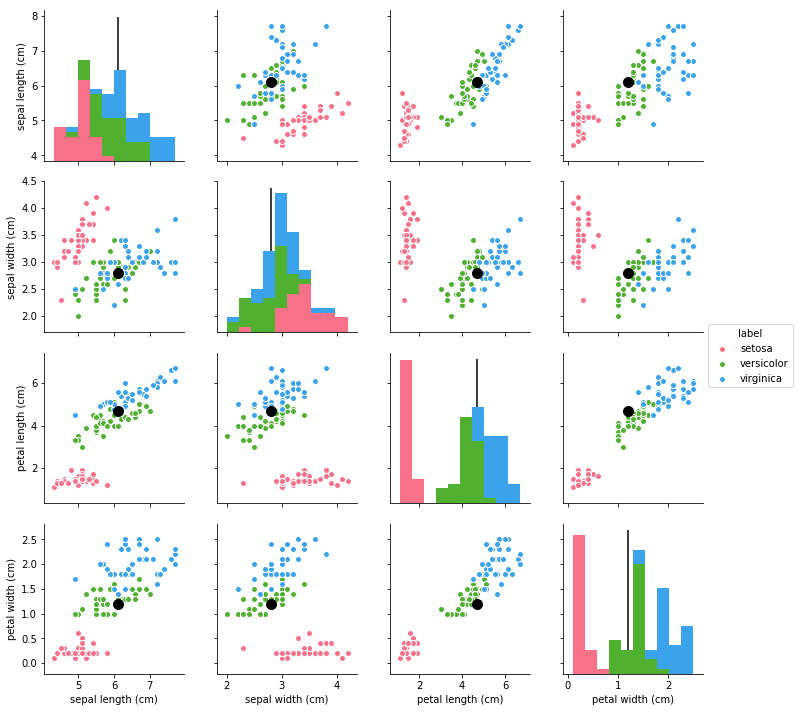

In [38]:
idx=0
instance = x_test[idx].reshape(1,-1)
instance_series = pd.Series(instance.ravel(), index=iris.feature_names)
x_train_df = pd.DataFrame(x_train, columns=iris.feature_names)
xy_train_df = x_train_df
xy_train_df['label'] = iris.target_names[y_train]
ax = sns.pairplot(x_train_df, hue='label', palette="husl",hue_order=iris.target_names)
for ix in range(4):
    for iy in range(4):
        x = ax.x_vars[ix]
        y = ax.y_vars[iy]
        a = ax.axes[iy, ix]
        if x==y:
            a.vlines(instance_series[x], ymin=a.get_ylim()[0], ymax=a.get_ylim()[1])
        else:
            a.plot(instance_series[x], instance_series[y],'ko', markersize=10)

# Automatic Interpretation by Paths

In [58]:
!pip install treeinterpreter
from treeinterpreter import treeinterpreter as ti
prediction, bias, feature_contributions = ti.predict(rf, instance)
feature_contributions = feature_contributions.squeeze()
feature_contributions_df = pd.DataFrame(feature_contributions, 
                                        index=iris.feature_names, 
                                        columns=iris.target_names)

distributed 1.21.8 requires msgpack, which is not installed.
bootstrapped 0.0.1 has requirement matplotlib==1.5.3, but you'll have matplotlib 2.2.2 which is incompatible.
bootstrapped 0.0.1 has requirement numpy==1.11.1, but you'll have numpy 1.14.3 which is incompatible.
bootstrapped 0.0.1 has requirement pandas==0.18.1, but you'll have pandas 0.23.0 which is incompatible.


In [59]:
display(pd.Series(prediction.ravel(), index=iris.target_names, name='probability').to_frame())
display(feature_contributions_df)

,probability
setosa,0.000000
versicolor,0.944817
virginica,0.055183


,setosa,versicolor,virginica
sepal length (cm),-0.076108,0.087888,-0.011780
sepal width (cm),-0.010526,-0.010401,0.020927
petal length (cm),-0.125747,0.260800,-0.135052
petal width (cm),-0.084940,0.257423,-0.172484


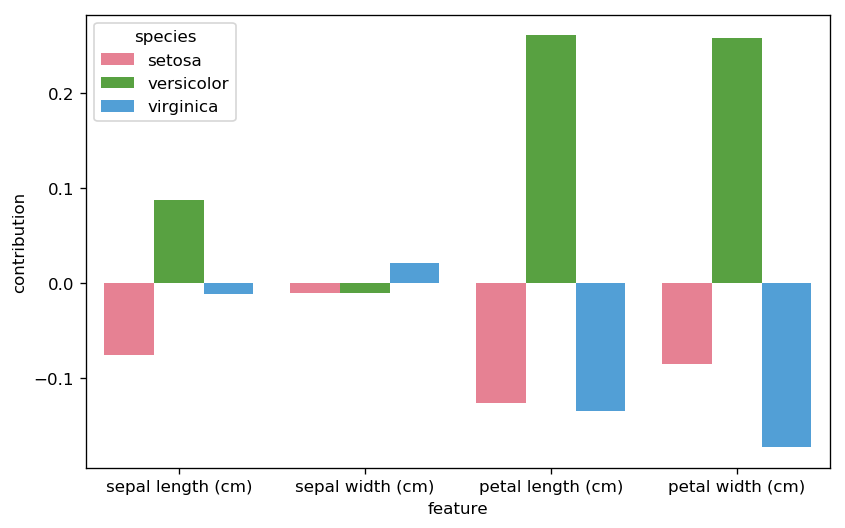

In [56]:
feature_contributions_tidy = feature_contributions_df.unstack().reset_index()
feature_contributions_tidy.columns=['species','feature','contribution']
plt.figure(figsize=(8,5), dpi=120)
sns.barplot(data=feature_contributions_tidy, x='feature', y='contribution', 
            hue='species', palette="husl", hue_order=iris.target_names);

# Summary
![](https://image.ibb.co/jwyirT/open_blackbox.jpg)
* Trees ensemble predictions are interpretable in the dynamic (per instance) sense: can be presented as a sum of individual feature contributions
* This opens up opportunities in practical machine learning and data science tasks, e.g.:
    * Explain to an analyst why a particular prediction is made
    * Debug models when results are unexpected

# References
1. http://blog.datadive.net/interpreting-random-forests/
2. http://web.stanford.edu/~hastie/ElemStatLearn/